<a href="https://colab.research.google.com/github/ADIthaker/CNN-Techniques/blob/master/ImageSuperRes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d andrewmvd/dog-and-cat-detection

 99% 1.02G/1.03G [00:08<00:00, 139MB/s]
100% 1.03G/1.03G [00:08<00:00, 135MB/s]


In [5]:
!mkdir ~/.keras/datasets
!unzip -q dog-and-cat-detection.zip -d ~/.keras/datasets/dogscats

In [6]:
!ls -la  ~/.keras/datasets

total 12
drwxr-xr-x 3 root root 4096 Sep 20 05:18 .
drwxr-xr-x 3 root root 4096 Sep 20 05:18 ..
drwxr-xr-x 4 root root 4096 Sep 20 05:18 dogscats


In [7]:
import pathlib
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *

In [8]:
def build_srcnn(height, width, depth):
  input = Input(shape=(height, width, depth))
  x = Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='he_normal')(input)
  x = ReLU()(x)
  x = Conv2D(filters=32, kernel_size=(1,1), kernel_initializer='he_normal')(x)
  x = ReLU()(x)
  output = Conv2D(filters=depth, kernel_size=(5, 5), kernel_initializer='he_normal')(x)
  return Model(input, output)

In [9]:
def resize_image(image_array, factor):
  original_image = Image.fromarray(image_array)
  new_size = np.array(original_image.size)*factor
  new_size = new_size.astype(np.int32)
  resized = original_image.resize(new_size)
  resized = img_to_array(resized)
  resized = resized.astype(np.uint8)
  return resized

In [11]:
def tight_crop_image(image):
  height, width = image.shape[:2]
  width -=int(width%SCALE)
  height -=int(height%SCALE)
  return image[:height, :width]

In [12]:
def crop_input(image, x , y):
  y_slice = slice(y, y + INPUT_DIM)
  x_slice = slice(x, x + INPUT_DIM)
  return image[y_slice, x_slice]

In [14]:
def downsize_upsize_image(image):
  scaled = resize_image(image, 1.0 / SCALE)
  scaled = resize_image(scaled, SCALE / 1.0)
  return scaled

In [16]:
def crop_output(image, x, y):
  y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
  x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
  return image[y_slice, x_slice]

In [17]:
SEED = 999
np.random.seed(SEED)

In [18]:
file_patten = (pathlib.Path.home() / '.keras' /
'datasets' /
'dogscats' / 'images' / '*.png')
file_pattern = str(file_patten)
dataset_paths = [*glob(file_pattern)]

In [19]:
SUBSET_SIZE = 1500
dataset_paths = np.random.choice(dataset_paths,
SUBSET_SIZE)

In [20]:
SCALE = 2.0
INPUT_DIM = 33
LABEL_SIZE = 21
PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)
STRIDE = 14

In [21]:
data = []
labels = []
for image_path in dataset_paths:
  image = load_img(image_path)
  image = img_to_array(image)
  image = image.astype(np.uint8)
  image = tight_crop_image(image)
  scaled = downsize_upsize_image(image)
  height , width = image.shape[:2]
  for y in range(0, height - INPUT_DIM + 1, STRIDE):
    for x in range(0, width -INPUT_DIM +1, STRIDE):
      crop = crop_input(scaled, x ,y)
      target = crop_output(image, x, y)
      data.append(crop)
      labels.append(target)
data = np.array(data)
labels = np.array(labels)

In [22]:
EPOCHS = 12
optimizer = Adam(lr=1e-3, decay=1e-3 /EPOCHS)
model = build_srcnn(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss='mse', optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
BATCH_SIZE = 64
model.fit(data, labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/12
16874/16874 [==============================] - 185s 9ms/step - loss: 126.8002
Epoch 2/12
16874/16874 [==============================] - 153s 9ms/step - loss: 94.1777
Epoch 3/12
16874/16874 [==============================] - 154s 9ms/step - loss: 92.2402
Epoch 4/12
16874/16874 [==============================] - 153s 9ms/step - loss: 91.3854
Epoch 5/12
16874/16874 [==============================] - 154s 9ms/step - loss: 90.9018
Epoch 6/12
16874/16874 [==============================] - 155s 9ms/step - loss: 90.5829
Epoch 7/12
16874/16874 [==============================] - 156s 9ms/step - loss: 90.3481
Epoch 8/12
16874/16874 [==============================] - 156s 9ms/step - loss: 90.1635
Epoch 9/12
16874/16874 [==============================] - 156s 9ms/step - loss: 90.0219
Epoch 10/12
16874/16874 [==============================] - 156s 9ms/step - loss: 89.8975
Epoch 11/12
16874/16874 [==============================] - 157s 9ms/step - loss: 89.7972
Epoch 12/12
16874/16874 [====

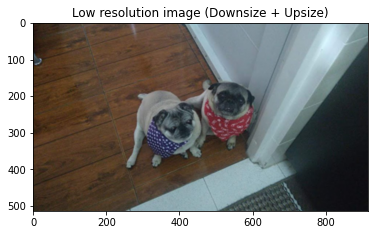

In [24]:
image = load_img('dogs.jpg')
image = img_to_array(image)
image = image.astype(np.uint8)
image = tight_crop_image(image)
scaled = downsize_upsize_image(image)
plt.title('Low resolution image (Downsize + Upsize)')
plt.imshow(scaled)
plt.show()

In [26]:
output = np.zeros(scaled.shape)
height, width = output.shape[:2]
for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
  for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
    crop = crop_input(scaled, x, y)
    image_batch = np.expand_dims(crop, axis=0)
    prediction = model.predict(image_batch)
    new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
    prediction = prediction.reshape(new_shape)
    output_y_slice = slice(y + PAD, y + PAD +LABEL_SIZE)
    output_x_slice = slice(x + PAD, x + PAD +LABEL_SIZE)
    output[output_y_slice, output_x_slice] = prediction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


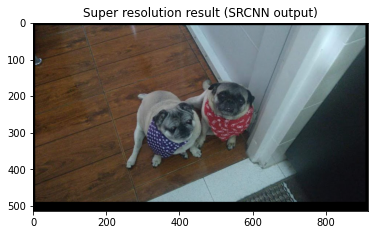

In [27]:
plt.title('Super resolution result (SRCNN output)')
plt.imshow(output / 255)
plt.show()